In [1]:
# Import the necessary packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import fiona
from zipfile import ZipFile
import os
import seaborn as sns
# import geoplot # For creating voronoi polygons
from shapely.ops import unary_union
from geovoronoi import voronoi_regions_from_coords # For creating voronoi polygons
import numpy as np

In [2]:
# Path to GIS files
path = "E:/documents/gis800_articles/jupyter/python_voronoi"

In [3]:
# Show the canada shapefile
# First extract the shapefile downloaded from this link-- (https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/files-fichiers/2016/lcd_000b16a_e.zip)
with ZipFile(os.path.join(path, 'canada_files.zip'), 'r') as zObject:
    zObject.extractall(os.path.join(path, 'canada_extracted'))

<AxesSubplot: >

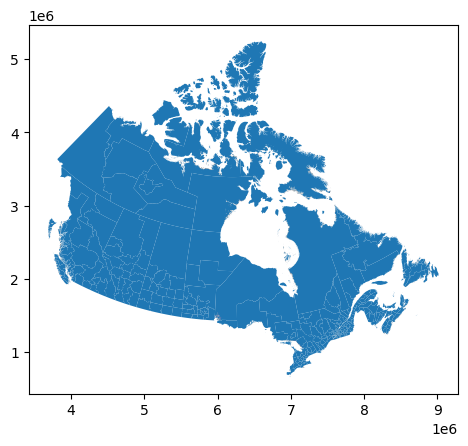

In [4]:
# Now show the Canada shapefile
canadaCensusDivisions = gpd.read_file(os.path.join(path, 'canada_extracted', 'lcd_000b16a_e.shp'))
canadaCensusDivisions.plot()

In [5]:
# Read the first few rows of canadaCensusDivisions shapefile
canadaCensusDivisions.head(8)

,CDUID,CDNAME,CDTYPE,PRUID,PRNAME,geometry
0,4621,Division No. 21,CDR,46,Manitoba,"POLYGON ((5753862.131 2114062.380, 5752944.009..."
1,4622,Division No. 22,CDR,46,Manitoba,"POLYGON ((6204057.683 2107140.734, 6204737.266..."
2,4623,Division No. 23,CDR,46,Manitoba,"MULTIPOLYGON (((6039656.509 2636304.343, 60396..."
3,4701,Division No. 1,CDR,47,Saskatchewan,"POLYGON ((5422081.934 1612417.386, 5422521.154..."
4,4702,Division No. 2,CDR,47,Saskatchewan,"POLYGON ((5270212.334 1641442.671, 5270216.591..."
5,4703,Division No. 3,CDR,47,Saskatchewan,"POLYGON ((5119063.454 1675925.746, 5120431.731..."
6,4704,Division No. 4,CDR,47,Saskatchewan,"POLYGON ((5004088.034 1735837.169, 5004359.171..."
7,4705,Division No. 5,CDR,47,Saskatchewan,"POLYGON ((5421578.606 1733112.871, 5421576.797..."


In [6]:
# Extract the Canadian hospitals excel file from this link -- https://www150.statcan.gc.ca/n1/en/pub/13-26-0001/2020001/ODHF_v1.1.zip?st=WbSsnZ-r
# First extract the zipfile
with ZipFile(os.path.join(path, 'ODHF_v1.1.zip'), 'r') as zObject:
    zObject.extractall(os.path.join(path, 'canada_hospitals'))


In [7]:
# Open and display the first 10 rows of the Canadian hospital dataset
canadaHospitalsData = pd.read_csv(os.path.join(path, 'canada_hospitals', 'ODHF_v1.1', 'odhf_v1.1.csv'), encoding = 'unicode_escape')
canadaHospitalsData.head()

,index,facility_name,source_facility_type,odhf_facility_type,provider,unit,street_no,street_name,postal_code,city,province,source_format_str_address,CSDname,CSDuid,Pruid,latitude,longitude
0,1,Advanced Facial & Nasal Surgery Centre,other,Ambulatory health care services,Canadian Institute for Health Information,NaN,NaN,NaN,T5M 4G5,edmonton,ab,NaN,Edmonton,NaN,48,NaN,NaN
1,10,Alberta Children's Hospital,pediatric,Hospitals,Public Health Agency of Canada,NaN,28,oki dr nw,T3B 6A8,calgary,ab,28 Oki Dr NW,Calgary,4806016.0,48,51.074582,-114.148426
2,100,Devon General Hospital,general,Hospitals,Public Health Agency of Canada,NaN,101,erie st s,T9G 1A6,devon,ab,101 erie st. s. devon ab t9g 1a6,Devon,4811018.0,48,53.351493,-113.730785
3,1000,Kimbelee Place,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,12935,96 ave,V3V 7K6,surrey,bc,12935 96th ave surrey bc v3v 7k6,Surrey,5915004.0,59,49.177418,-122.864118
4,1001,Kimberley Special Care Home,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,386,2 ave,V1A 2Z6,kimberley,bc,386 2 ave kimberley bc v1a 2z6,Kimberley,5901028.0,59,49.689998,-115.989647


In [8]:
# Remove those rows where the Latitude is NaN
canadaHospitalsData2 = canadaHospitalsData.dropna(axis=0, subset=['latitude', 'longitude'], how='any')
canadaHospitalsData2.head(10)

,index,facility_name,source_facility_type,odhf_facility_type,provider,unit,street_no,street_name,postal_code,city,province,source_format_str_address,CSDname,CSDuid,Pruid,latitude,longitude
1,10,Alberta Children's Hospital,pediatric,Hospitals,Public Health Agency of Canada,NaN,28,oki dr nw,T3B 6A8,calgary,ab,28 Oki Dr NW,Calgary,4806016.0,48,51.074582,-114.148426
2,100,Devon General Hospital,general,Hospitals,Public Health Agency of Canada,NaN,101,erie st s,T9G 1A6,devon,ab,101 erie st. s. devon ab t9g 1a6,Devon,4811018.0,48,53.351493,-113.730785
3,1000,Kimbelee Place,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,12935,96 ave,V3V 7K6,surrey,bc,12935 96th ave surrey bc v3v 7k6,Surrey,5915004.0,59,49.177418,-122.864118
4,1001,Kimberley Special Care Home,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,386,2 ave,V1A 2Z6,kimberley,bc,386 2 ave kimberley bc v1a 2z6,Kimberley,5901028.0,59,49.689998,-115.989647
5,1002,Kinetic Energy Health and Wellness Centre,NaN,Ambulatory health care services,Province of British Columbia,NaN,207-450,lansdowne street,V2C 1Y4,kamloops,bc,207-450 lansdowne street kamloops bc v2c 1y4,Kamloops,5933042.0,59,50.677060,-120.329500
6,1003,King Edward House,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,820,e king edward ave,V5V 2E4,vancouver,bc,820 e king edward ave vancouver bc v5v 2e4,Vancouver,5915022.0,59,49.248353,-123.087045
7,1004,Kingfisher Place,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,4328,crystal drive,V1T 8V5,vernon,bc,4328 crystal drive vernon bc v1t 8v5,Vernon,5937014.0,59,50.276153,-119.244537
8,1005,Kinghaven Treatment Centre,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,31250,king rd,V2T 6C2,abbotsford,bc,31250 king rd abbotsford bc v2t 6c2,Abbotsford,5909052.0,59,49.030749,-122.358792
9,1006,Kings House,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,8512,164 st,V4N 1E5,surrey,bc,8512 164th st surrey bc v4n 1e5,Surrey,5915004.0,59,49.157599,-122.767254
10,1007,Kinsmen Lodge,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,9650,137a st,V3T 4H9,surrey,bc,9650 137a st surrey bc v3t 4h9,Surrey,5915004.0,59,49.177735,-122.841799


C:\Users\gachuhi\anaconda3\envs\python-gis\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

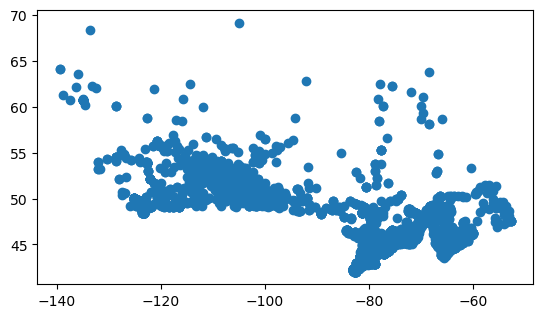

In [9]:
canadaHospitalsGdf = gpd.GeoDataFrame(canadaHospitalsData2, 
                                    geometry=gpd.points_from_xy(canadaHospitalsData2['longitude'], 
                                                               canadaHospitalsData2['latitude']), 
                                    crs='+init=epsg:4326')

canadaHospitalsGdf.plot()

In [10]:
# Change crs of canadaCensusDivision
canadaCensusDivisions2 = canadaCensusDivisions.to_crs('+init=epsg:4326')

C:\Users\gachuhi\anaconda3\envs\python-gis\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


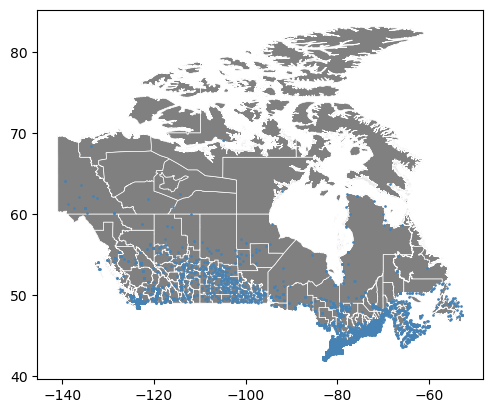

In [11]:
# Overlay the hospitals shapefile over the Canada administrative shapefile
# Setup figure and axis
fig, ax = plt.subplots(1)

# Add the Canadian administrative shapefile on to axis 'ax'
canadaCensusDivisions2.plot(ax=ax, facecolor='grey', edgecolor='white', linewidth=0.5)

# Add a layer of hospital points data on top of axis 'ax'
canadaHospitalsGdf.plot(ax=ax, color='steelblue', markersize=0.8)

# Display the data
plt.show()

In [12]:
# # Create voronoi polygons
# voronoi = geoplot.voronoi(df=canadaHospitalsGdf,
#                     projection='+init=epsg:4326',
#                     clip=canadaCensusDivisions2,
#                     # hue='provider',
#                     cmap='magma',
#                      legend=True,
#                           edgecolor='white',
#                           linewidth=0.2
#                     )


In [13]:
canadaHospitalsGdf.head()

,index,facility_name,source_facility_type,odhf_facility_type,provider,unit,street_no,street_name,postal_code,city,province,source_format_str_address,CSDname,CSDuid,Pruid,latitude,longitude,geometry
1,10,Alberta Children's Hospital,pediatric,Hospitals,Public Health Agency of Canada,NaN,28,oki dr nw,T3B 6A8,calgary,ab,28 Oki Dr NW,Calgary,4806016.0,48,51.074582,-114.148426,POINT (-114.14843 51.07458)
2,100,Devon General Hospital,general,Hospitals,Public Health Agency of Canada,NaN,101,erie st s,T9G 1A6,devon,ab,101 erie st. s. devon ab t9g 1a6,Devon,4811018.0,48,53.351493,-113.730785,POINT (-113.73078 53.35149)
3,1000,Kimbelee Place,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,12935,96 ave,V3V 7K6,surrey,bc,12935 96th ave surrey bc v3v 7k6,Surrey,5915004.0,59,49.177418,-122.864118,POINT (-122.86412 49.17742)
4,1001,Kimberley Special Care Home,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,386,2 ave,V1A 2Z6,kimberley,bc,386 2 ave kimberley bc v1a 2z6,Kimberley,5901028.0,59,49.689998,-115.989647,POINT (-115.98965 49.69000)
5,1002,Kinetic Energy Health and Wellness Centre,NaN,Ambulatory health care services,Province of British Columbia,NaN,207-450,lansdowne street,V2C 1Y4,kamloops,bc,207-450 lansdowne street kamloops bc v2c 1y4,Kamloops,5933042.0,59,50.677060,-120.329500,POINT (-120.32950 50.67706)


In [14]:
canadaCensusDivisions2.head()

,CDUID,CDNAME,CDTYPE,PRUID,PRNAME,geometry
0,4621,Division No. 21,CDR,46,Manitoba,"POLYGON ((-98.98629 54.99338, -98.98689 54.921..."
1,4622,Division No. 22,CDR,46,Manitoba,"POLYGON ((-91.80175 55.15887, -91.79088 55.158..."
2,4623,Division No. 23,CDR,46,Manitoba,"MULTIPOLYGON (((-94.82341 59.99352, -94.82398 ..."
3,4701,Division No. 1,CDR,47,Saskatchewan,"POLYGON ((-102.82454 50.04735, -102.81826 50.0..."
4,4702,Division No. 2,CDR,47,Saskatchewan,"POLYGON ((-104.99185 50.04669, -104.99179 50.0..."


In [15]:
##
# canadaBoundary = gpd.read_file(os.path.join(path, 'dissolved', 'canada_dissolved.shp'))

In [16]:
# canadaBoundary = canadaBoundary.to_crs('+init=epsg:4326')

In [17]:
canadaBoundary = gpd.read_file(os.path.join(path, 'dissolved', 'canada_dissolved_4326.shp'))

<AxesSubplot: >

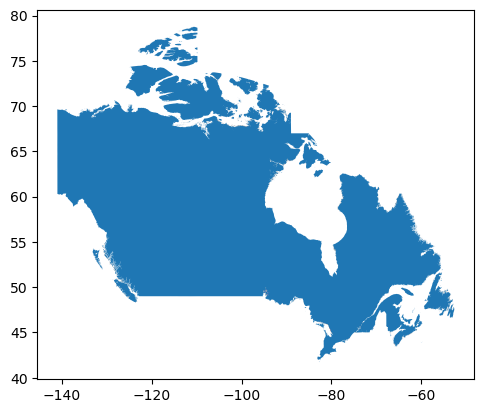

In [18]:
# Plot the Canada boundary
%matplotlib inline
canadaBoundary.plot()

In [19]:
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

In [20]:
# Dataset of canada hospitals too huge
canadaHospitalsGdf2 = canadaHospitalsGdf.loc[canadaHospitalsGdf['source_facility_type']=='general']

      

In [21]:
# Length of the General hospitals dataset
len(canadaHospitalsGdf2)

533

In [22]:
# Take sample of just 50 rows
canadaHospitalsGdf3 = canadaHospitalsGdf2.sample(n=50)
print("\nLength of sampled dataset")
len(canadaHospitalsGdf3)


Length of sampled dataset


50

In [23]:
# Get coordinates
coords = points_to_coords(canadaHospitalsGdf3.geometry)

In [24]:
boundaryShape = unary_union(canadaBoundary.geometry)

In [25]:
# Calculate voronoi regions
poly_shapes, pts = voronoi_regions_from_coords(coords, boundaryShape)

C:\Users\gachuhi\anaconda3\envs\python-gis\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\gachuhi\anaconda3\envs\python-gis\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Users\gachuhi\anaconda3\envs\python-gis\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\gachuhi\anaconda3\envs\python-gis\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coor

AttributeError: 'int' object has no attribute 'coords'

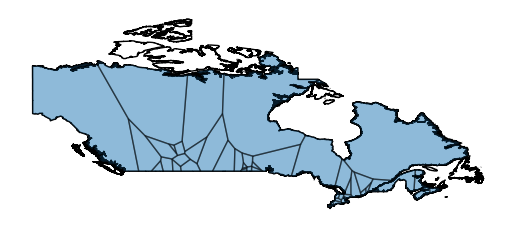

In [26]:
# Plot the voronois
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, boundaryShape, poly_shapes, pts)
ax.set_title('Voronoi regions of Hospitals in Canada')
# plt.tight_layout()
plt.show()

In [27]:
coords

array([[-100.242086 ,   50.0351804],
       [-122.8916374,   49.2264136],
       [-110.199018 ,   54.4658735],
       [ -98.787451 ,   49.412453 ],
       [ -74.718312 ,   45.029921 ],
       [ -64.7862138,   46.0980252],
       [ -79.089464 ,   43.094227 ],
       [ -99.287091 ,   49.559843 ],
       [-102.6381096,   50.1023016],
       [ -80.016767 ,   45.340743 ],
       [-123.7233231,   48.7850092],
       [ -96.8877138,   50.1574965],
       [-111.890977 ,   50.5676564],
       [ -75.9324814,   45.6484041],
       [-109.29367  ,   53.090537 ],
       [-113.486    ,   53.55136  ],
       [ -64.325971 ,   45.409197 ],
       [ -83.5624626,   46.2630206],
       [-113.730785 ,   53.351493 ],
       [-106.696366 ,   52.126313 ],
       [ -81.22543  ,   42.960029 ],
       [ -79.8543243,   43.2617528],
       [ -74.356786 ,   49.913688 ],
       [-112.788581 ,   53.762612 ],
       [ -64.6531608,   47.7916389],
       [-117.7959708,   50.2382819],
       [ -79.314359 ,   45.04781  ],
 

In [28]:
# Convert to numpy array
coords2 = np.asarray(coords)
coords2

array([[-100.242086 ,   50.0351804],
       [-122.8916374,   49.2264136],
       [-110.199018 ,   54.4658735],
       [ -98.787451 ,   49.412453 ],
       [ -74.718312 ,   45.029921 ],
       [ -64.7862138,   46.0980252],
       [ -79.089464 ,   43.094227 ],
       [ -99.287091 ,   49.559843 ],
       [-102.6381096,   50.1023016],
       [ -80.016767 ,   45.340743 ],
       [-123.7233231,   48.7850092],
       [ -96.8877138,   50.1574965],
       [-111.890977 ,   50.5676564],
       [ -75.9324814,   45.6484041],
       [-109.29367  ,   53.090537 ],
       [-113.486    ,   53.55136  ],
       [ -64.325971 ,   45.409197 ],
       [ -83.5624626,   46.2630206],
       [-113.730785 ,   53.351493 ],
       [-106.696366 ,   52.126313 ],
       [ -81.22543  ,   42.960029 ],
       [ -79.8543243,   43.2617528],
       [ -74.356786 ,   49.913688 ],
       [-112.788581 ,   53.762612 ],
       [ -64.6531608,   47.7916389],
       [-117.7959708,   50.2382819],
       [ -79.314359 ,   45.04781  ],
 

In [30]:
# Calculate voronoi regions
poly_shapes2, pts2 = voronoi_regions_from_coords(coords2, boundaryShape)

In [35]:
## Calculate voronoi regions
## poly_shapes2, pts2, poly_to_pt_assignments2 = voronoi_regions_from_coords(coords2, boundaryShape, per_geom=True)

ValueError: not enough values to unpack (expected 3, got 2)

C:\Users\gachuhi\anaconda3\envs\python-gis\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\gachuhi\anaconda3\envs\python-gis\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Users\gachuhi\anaconda3\envs\python-gis\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\gachuhi\anaconda3\envs\python-gis\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coor

AttributeError: 'int' object has no attribute 'coords'

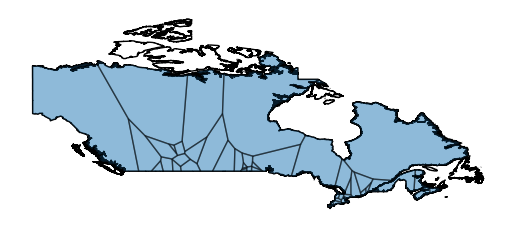

In [34]:
# Plot the voronois
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, boundaryShape, poly_shapes2, pts2)
ax.set_title('Voronoi regions of Hospitals in Canada')
# plt.tight_layout()
plt.show()

AttributeError: 'dict' object has no attribute 'plot'

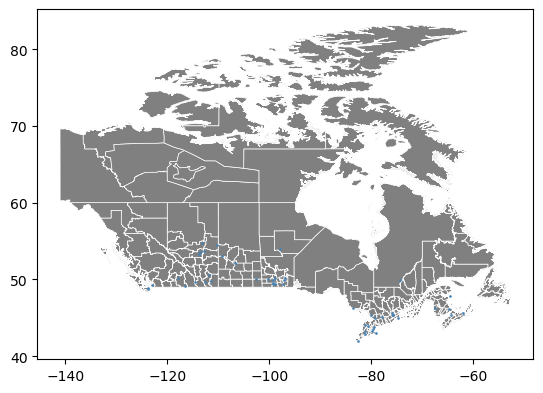

In [33]:
# Draw with matplotlib
fig, ax = plt.subplots(1)

# Add the Canadian administrative shapefile on to axis 'ax'
canadaCensusDivisions2.plot(ax=ax, facecolor='grey', edgecolor='white', linewidth=0.5)

# Add a layer of hospital points data on top of axis 'ax'
canadaHospitalsGdf3.plot(ax=ax, color='steelblue', markersize=0.8)

poly_shapes2.plot(ax=ax, edgecolor='red', linewidth=0.5)

# Display the data
plt.show()